In [1]:
!pip install dmba
!pip install mord
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import statsmodels.formula.api as sm
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score

     |████████████████████████████████| 11.8 MB 6.9 MB/s 
  Created wheel for mord: filename=mord-0.6-py3-none-any.whl size=6006 sha256=04ff35eb998449808b28af363a71e26aee7e4e161b1083cebfdc967bb7f20afc
  Stored in directory: /root/.cache/pip/wheels/80/1d/8a/bef1a01b6a3c91494905d161d5426c181819f9730a773141eb
Successfully built mord


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


no display found. Using non-interactive Agg backend


In [2]:
auctions_df = pd.read_csv('eBayAuctions.csv')

In [3]:
auctions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Category      1972 non-null   object 
 1   currency      1972 non-null   object 
 2   sellerRating  1972 non-null   int64  
 3   Duration      1972 non-null   int64  
 4   endDay        1972 non-null   object 
 5   ClosePrice    1972 non-null   float64
 6   OpenPrice     1972 non-null   float64
 7   Competitive?  1972 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 123.4+ KB


In [4]:
auctions_df.head()

,Category,currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


In [5]:
predictors = ['Category','currency','sellerRating','Duration','endDay','ClosePrice','OpenPrice']
outcome = 'Competitive?'

In [6]:
# partition data
X = pd.get_dummies(auctions_df[predictors], drop_first=True)
y = auctions_df[outcome]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.4, random_state = 1)

In [7]:
log_re = LogisticRegression()

In [8]:
# fit the model
log_re.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [9]:
print(pd.DataFrame({'coeff':log_re.coef_[0]}, index = X.columns).transpose())

       sellerRating  Duration  ClosePrice  OpenPrice  Category_Automotive  \
coeff     -0.000032 -0.044752    0.083976  -0.098913            -0.329282   

       Category_Books  Category_Business/Industrial  \
coeff        0.163053                      0.145616   

       Category_Clothing/Accessories  Category_Coins/Stamps  \
coeff                      -0.810461              -0.294596   

       Category_Collectibles  ...  Category_SportingGoods  \
coeff               0.176205  ...                0.034903   

       Category_Toys/Hobbies  currency_GBP  currency_US  endDay_Mon  \
coeff               0.484906       0.70578     0.086494    0.550648   

       endDay_Sat  endDay_Sun  endDay_Thu  endDay_Tue  endDay_Wed  
coeff   -0.543776   -0.288633    0.385482    0.022653    -0.26504  

[1 rows x 29 columns]


In [10]:
# Q1: An interesting find is that duration is negatively correlated with competitiveness. This could be because items with low demand tend to be listed for a longer duration, 
# so it is not necessarily that a long duration causes a listing to become less competitive in and of itself.
# ClosePrice is positively correlated with competitiveness, which isn't really a surprise. The higher the closing price, the more likely it is that multiple bids were placed.
# OpenPrice is negatively correlated with competitiveness, which again isn't really a surprise. The lower the opening price, the more likely it is that people will bid.
# Among the categories, Clothing/Accessories, Automotive, and Coins/Stamps seem to be the least competitive, while Toys/Hobbies, Collectibles, and Books seem to be more competitive.

In [11]:
# evaluate the model
classificationSummary(y_valid, log_re.predict(X_valid))

Confusion Matrix (Accuracy 0.7465)

       Prediction
Actual   0   1
     0 288  65
     1 135 301


In [12]:
# Q2 The model is able to predict reasonably well, but it is unrealistic for this model to perform this well in a real-world scenario.
# This is because the model has access to the ClosePrice column, which is impossible to know in a real-world situation.

In [13]:
rw_predictors = predictors = ['Category','currency','sellerRating','Duration','endDay','OpenPrice']

In [14]:
# partition data
X = pd.get_dummies(auctions_df[rw_predictors], drop_first=True)
y = auctions_df[outcome]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.4, random_state = 1)

In [15]:
# fit the model
log_re.fit(X_train, y_train)

LogisticRegression()

In [16]:
log_re_pred = log_re.predict(X_valid)
log_re_proba = log_re.predict_proba(X_valid)
log_result = pd.DataFrame({'actual':y_valid, 
                           'p(0)':[p[0]for p in log_re_proba],
                           'p(1)':[p[1]for p in log_re_proba],
                           'predicted':log_re_pred})

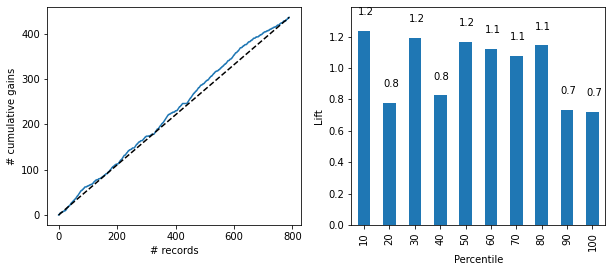

In [17]:
df = log_result.sort_values(by=['p(1)'], ascending = False)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))

gainsChart(df.actual, ax=axes[0])
liftChart(df.actual, title=False, ax=axes[1])

plt.show()

In [18]:
# evaluate the model
classificationSummary(y_valid, log_re.predict(X_valid))

Confusion Matrix (Accuracy 0.5856)

       Prediction
Actual   0   1
     0  70 283
     1  44 392


In [21]:
# Q3 The accuracy seems to have gone way down without being able to use the data from the ClosePrice column. In particular, the model seems to overclassify competitiveness more often.
# However, this is more representative of a real-world scenario as in the real world it is impossible to know the closing price ahead of time.

In [22]:
# Q4 Again, ClosePrice is positively correlated with competitiveness, because the higher the closing price, the more likely it is that multiple bids were placed.
# This is why it isn't useful as a real-world predictor. However, it does have practical use as an outcome rather than a predictor variable.
# In a real-world situation, the next step could be to not only predict competitiveness but also closing price. This would likely require more data and would no longer be a simple classification problem.